In [15]:
# dependencies
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import sys
import numpy as np
import pandas as pd
import os.path
import Utils.yolo_utils as yolo
import Utils.Plate_Detection as plteD
import Utils.ImageEnhancementV2 as ImgEn
import Utils.PlateOCR as PltOCR

%matplotlib inline

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
use_haze_removal = False
detect_truck_plate_brand = False

In [3]:
input_file_name = "Bosch_urn-uuid-00075faa-12bd-bd12-aa5f-0700075faa5f_2019-11-20_12-11-52(1).mp4"

input_directory_path= 'Videos/'

full_truck_out_directory_path = "Cropped_Images/"

output_video_directory = "Output_Video/"

weights_directory = "Weights/"

Truck_labels = [name for name in os.listdir("Cropped_ClassifiedTruckType/")]

file_input_path = input_directory_path+input_file_name

print(file_input_path)

Videos/Bosch_urn-uuid-00075faa-12bd-bd12-aa5f-0700075faa5f_2019-11-20_12-11-52(1).mp4


In [4]:
#image = mpimg.imread(file_input_path)

inpWidth = 608  #608     #Width of network's input image
inpHeight = 608 #608     #Height of network's input image

#plt.imshow(image);

In [5]:
w_size=15
a_omega=0.95
gf_w_size=200
eps=1e-6

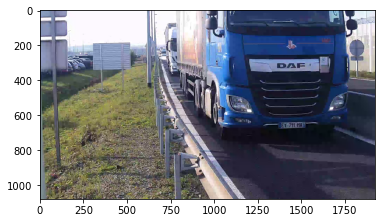

In [6]:
# Open the input file
vid_cap = cv.VideoCapture(file_input_path)
success, image = vid_cap.read()
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [9]:
# Load names of classes
labels_file = "darknet/data/coco.names"

In [10]:
labels = None
with open(labels_file, 'rt') as f:
    labels = f.read().rstrip('\n').split('\n')

In [11]:
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "darknet/cfg/yolov3.cfg";
modelWeights = "Weights/yolov3.weights";

# Load Plate Detection Model

In [ ]:
from keras.models import load_model


image_height=128
image_width=128

weights_directory = "Weights/"
plate_model = load_model(weights_directory+"adam_TruckPlate_Model.h5")

# Load Plate OCR Model

In [ ]:
json_file = open('../Plate_OCR/MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
plate_model = model_from_json(loaded_model_json)
plate_model.load_weights("../Plate_OCR/License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('../Plate_OCR/license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

# Load Brand Model

In [15]:
from keras.models import load_model


image_height=128
image_width=128

weights_directory = "Weights/"
brand_model = load_model(weights_directory+"adam_TruckBrand_Model_BrandOnly.h5")

In [20]:
# Get the labels
confThreshold = 0.5
nmsThreshold = 0.4
# Load the weights and configutation to form the pretrained YOLOv3 model
net = yolo.Create_Yolo_Model(modelConfiguration, modelWeights)

In [21]:
width = int(vid_cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(vid_cap.get(cv.CAP_PROP_FRAME_HEIGHT))
res=(int(height), int(width))
fourcc = cv.VideoWriter_fourcc('M','J','P','G')
video_out = cv.VideoWriter(output_video_directory+input_file_name+'_output.avi', fourcc, 20.0, res)

In [22]:
truck_plate = None
cropped = None

# Detect Truck, Plate, Brand From Video

In [ ]:
vid_cap = cv.VideoCapture(file_input_path)
hasFrame, frame = vid_cap.read()

count = 1


while hasFrame: #and count<100:        
    # get frame from the video
    hasFrame, frame = vid_cap.read() #frame: an image object from cv2
    height, width = None, None

    # Stop the program if reached end of video
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
        
    if not hasFrame:
        cv.waitKey(0)
        break   

    if resize_frame:
        frame = resize_image(frame, scale_percent=50)
    
    if use_haze_removal:    
        frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
        frame,_ = ImgEn.haze_removal(frame, w_size, a_omega, gf_w_size, eps)
        frame = frame.astype(np.uint8)
        
    cropped, boxes, confidences = yolo.Get_Truck(frame, net, labels, inpWidth, inpHeight, confThreshold, nmsThreshold)
    count+=1

    if cropped is not None:
        if cropped.shape[0] != 0 and cropped.shape[1] != 0 and cropped.shape[2] != 0:
            truck_plate = get_plate_image(cropped)
            
            #if detect_truck_plate_brand == True and truck_plate is not None :
            #    if truck_plate.shape[0] != 0 or truck_plate.shape[1] != 0 or truck_plate.shape[2] != 0:
            #        segements= segement_plate_contours(truck_plate)                            
            #        plate_text = get_plate_text(truck_plate, segements)
            #        print(plate_text)
            #        brandLabel = tm.get_brand_label(image, brand_template_images) 
            #        print(brandLabel)
    
    print("frame_"+str(count)+" Done...")
    
    # Write the frame
    
    #frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    cv.imshow('frame',frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
    
    video_out.write(frame.astype(np.uint8))
    
vid_cap.release()
cv.destroyAllWindows()